# Workflow example to generate timelapses

This example illustrates how to use an `EOWorkflow` to create time-lapses

### Create cloudless timelapse

Imports from `sentinelhub` and `eolearn` to set up workflow that creates a timelapse

In [1]:
from sentinelhub import BBox, CRS, MimeType, CustomUrlParam
import numpy as np
import datetime

In [2]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.core import EOPatch, FeatureType, LinearWorkflow
from eolearn.features import SimpleFilterTask
from eolearn.io import S2L1CWCSInputXarray

/home/ubuntu_FOGH/miniconda3/envs/py37_dev_eolearn/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Set up BBox of ROI and time interval

In [3]:
roi_bbox = BBox(bbox=[5.60, 52.68, 5.75, 52.63], crs=CRS.WGS84)
time_interval = ('2017-01-01', '2017-02-01')

This predicate function filters the images with a cloud coverage larger than a threshold to ensure images do not contain cloudy pixels

In [4]:
class MaxCCPredicate:
    def __init__(self, maxcc):
        self.maxcc = maxcc

    def __call__(self, img_cm):
        w, h, _ = img_cm.shape
        cc = np.sum(img_cm) / (w * h)
        return cc <= self.maxcc

Tasks of the workflow:
 * download S2 images (all 13 bands)
 * run `s2cloudless` to compute cloud masks
 * filter out images with cloud coverage larger than a given threshold (e.g. 0.05)

In [5]:
wcs_task = S2L1CWCSInputXarray(
    layer='BANDS-S2-L1C', 
    resx='20m',
    resy='20m',
    time_difference=datetime.timedelta(hours=2))

cloud_classifier = get_s2_pixel_cloud_detector(all_bands=True)
# TODO: AddCloudMaskTask needs to support xarray
# add_clm = AddCloudMaskTask(cloud_classifier, 
#                            'BANDS-S2-L1C', 
#                            cm_size_y='60m',
#                            cm_size_x='60m', 
#                            cmask_feature='clm', 
#                            cprobs_feature='clp')

# filter_task = SimpleFilterTask((FeatureType.MASK, 'clm'), MaxCCPredicate(maxcc=0.05))

Build and execute timelapse as chain of transforms

In [6]:
timelapse = LinearWorkflow(wcs_task)#, add_clm, filter_task)

result = timelapse.execute({
    wcs_task: {
        'bbox': roi_bbox,
        'time_interval': time_interval
    }
})

Get result as an eopatch

In [7]:
eopatch_clean, = [result[key] for key in result.keys()]
eopatch_clean

EOPatch(
  raster: <xarray.Dataset>
Dimensions:       (channel: 13, time: 4, x_coord: 506, y_coord: 278)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-03 2017-01-13 ... 2017-01-26
  * y_coord       (y_coord) float64 52.63 52.63 52.63 ... 52.68 52.68 52.68
  * x_coord       (x_coord) float64 52.63 52.54 52.44 52.35 ... 5.936 5.843 5.75
  * channel       (channel) <U3 'B01' 'B02' 'B03' 'B04' ... 'B10' 'B11' 'B12'
Data variables:
    BANDS-S2-L1C  (time, y_coord, x_coord, channel) float32 0.4469 ... 0.0625
    IS_DATA       (time, y_coord, x_coord) bool True True True ... True True
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 1.0
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2017-01-01', '2017-02-01')
  }
  bbox: BBox(((5.6, 52.63), (5.75, 52.

#### Help function to create GIFs

In [12]:
import imageio, os

def make_gif(images, project_dir, filename, fps):
    """
    Generates a GIF animation from an EOPatch.
    """
    with imageio.get_writer(os.path.join(project_dir, filename), mode='I', fps=fps) as writer:
            for time in images.time:
                writer.append_data(np.array(images.sel(time=time, channel=['B04', 'B03', 'B02']) * 2.5 * 255, dtype=np.uint8))

Write clean EOPatch to GIF

In [13]:
make_gif(images=eopatch_clean.raster['BANDS-S2-L1C'], project_dir='.',
         filename='eopatch_clean_xarray.gif', fps=3)

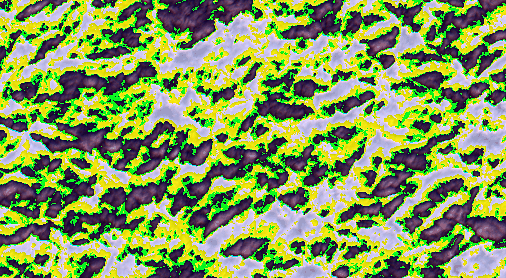

In [14]:
from IPython.display import Image

Image(filename="eopatch_clean_xarray.gif")

In [11]:
from IPython.display import Image

Image(filename="eopatch_clean.gif")

FileNotFoundError: [Errno 2] No such file or directory: 'eopatch_clean.gif'